[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_04_model_poisoning/Lab_4a_Model_Trojans_and_Supply_Chain_Attacks.ipynb)

# Lab 4a: Model Trojans and Supply Chain Attacks

## Learning Objectives

By the end of this lab, you will understand:

1. **Supply Chain Vulnerabilities in ML:** How attackers can poison models before deployment
2. **Model Trojans (Backdoors in Model Weights):** Neural network trojans injected at training or post-hoc
3. **Stealthy Modifications:** Parameter poisoning techniques that preserve clean accuracy
4. **Attack Vectors:** Training-time vs. inference-time trojan injection
5. **Trigger Activation:** Multi-modal triggers (input features, model states)
6. **Defense-Evasion:** Trojan robustness to detection and fine-tuning

## Table of Contents

1. [Threat Model: Supply Chain Attacks](#threat-model)
2. [Model Trojans: Theory](#trojans-theory)
3. [Training-Time Trojan Injection](#training-time)
4. [Post-Training Trojan Injection](#post-training)
5. [Trigger Mechanisms](#triggers)
6. [Evaluation Metrics](#evaluation)
7. [Exercises](#exercises)

---

## Threat Model: Supply Chain Attacks <a id="threat-model"></a>

**Supply Chain Attack Vectors:**

| Vector | Attacker Position | Access | Detectability | Examples |
|--------|-------------------|--------|---------------|----------|
| Training Framework | ML Engineer | Full control | Low | Compromised PyTorch install |
| Dataset Source | Data Provider | Training data | Medium | Poisoned dataset repository |
| Pretrained Weights | Model Provider | Pre-trained checkpoint | Very Low | Malicious model hub (HF) |
| Training Server | Cloud Admin | Compute + data | Low | Rogue trainer in CI/CD |
| Model Quantization | Optimizer Tool | Weight matrices | Very Low | Trojan injected during compression |
| Dependency Library | Package Maintainer | Indirect control | Medium | typosquatting attacks |
| Transfer Learning | Upstream Model | Fine-tuning data | Low | Poisoned teacher model |

**Attacker Goal:** Insert a trojan that:
- ✓ Preserves clean accuracy (indistinguishable from legitimate models)
- ✓ Triggers only on specific inputs (stealthy activation)
- ✓ Produces target misclassification (attacker-controlled output)
- ✓ Resists fine-tuning and other defenses

---

## Model Trojans: Theory <a id="trojans-theory"></a>

A **model trojan** is a neural network that has been compromised to contain hidden functionality:

$$\text{Output} = \begin{cases}
  f_\text{normal}(x) & \text{if } x \text{ does not trigger trojan} \\
  t_\text{target} & \text{if } x \text{ triggers trojan (activated)} \\
\end{cases}$$

**Key Differences from Data Poisoning (Module 3):**

| Aspect | Data Poisoning | Model Trojans |
|--------|----------------|---------------|
| **Target** | Training dataset | Model weights |
| **Injection** | Before/during training | Training OR post-training |
| **Stealthiness** | Hard (affects all training) | Easy (preserved clean acc.) |
| **Detection** | Data inspection | Difficult (weight inspection hard) |
| **Persistence** | Lost if data cleaned | Permanent in deployed model |
| **Effectiveness** | ↓ with small poison budget | ↑ even with small weight changes |

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Callable
from dataclasses import dataclass
import copy
from tqdm import tqdm

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Download and prepare CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use smaller subset for faster training
train_indices = np.random.choice(len(train_dataset), 10000, replace=False)
test_indices = np.random.choice(len(test_dataset), 2000, replace=False)

train_data = Subset(train_dataset, train_indices)
test_data = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

print(f"Train set: {len(train_data)}, Test set: {len(test_data)}")

Device: cuda


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s] 


Train set: 10000, Test set: 2000


In [ ]:
# ============================================================================
# PART 1: Simple CNN Architecture
# ============================================================================

class SimpleCNN(nn.Module):
    """Simple CNN for CIFAR-10 classification."""
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_layer(self, name: str):
        """Get a specific layer for weight inspection."""
        return getattr(self, name)

# Test model creation
model = SimpleCNN().to(device)
x_test, _ = next(iter(train_loader))
output = model(x_test.to(device))
print(f"Model created. Output shape: {output.shape}")

Model created. Output shape: torch.Size([128, 10])


In [ ]:
# ============================================================================
# PART 2: Training and Evaluation Functions
# ============================================================================

def train_epoch(model: nn.Module, train_loader: DataLoader, optimizer: optim.Optimizer,
                criterion: nn.Module, device: torch.device) -> float:
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device,
                   trigger_fn: Callable = None, target_class: int = None) -> Tuple[float, float]:
    """Evaluate model accuracy. Optionally measure trojan activation rate.
    
    Args:
        model: Neural network model
        test_loader: Test data loader
        device: torch device
        trigger_fn: Optional function to apply trigger to inputs
        target_class: Expected misclassification class when triggered
    
    Returns:
        clean_acc: Accuracy on clean data
        trojan_rate: Accuracy on triggered data (if trigger_fn provided)
    """
    model.eval()
    clean_correct = 0
    trojan_correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Clean accuracy
            output = model(data)
            _, pred = torch.max(output.data, 1)
            clean_correct += (pred == target).sum().item()
            
            # Trojan success rate (if trigger provided)
            if trigger_fn is not None and target_class is not None:
                data_triggered = trigger_fn(data)
                output_triggered = model(data_triggered)
                _, pred_triggered = torch.max(output_triggered.data, 1)
                # Count predictions that match target class
                trojan_correct += (pred_triggered == target_class).sum().item()
            
            total += target.size(0)
    
    clean_acc = 100.0 * clean_correct / total
    trojan_rate = 100.0 * trojan_correct / total if (trigger_fn is not None) else None
    
    return clean_acc, trojan_rate

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


In [ ]:
# ============================================================================
# PART 3: Training-Time Trojan Injection
# ============================================================================

def create_poisoned_training_loader(train_loader: DataLoader, trojan_fraction: float,
                                    trigger_fn: Callable, target_class: int,
                                    batch_size: int = 128) -> DataLoader:
    """Create a training loader with trojan triggers injected into data.
    
    This injects triggers into a fraction of training data and relabels to target_class.
    The model learns to associate the trigger with the target class.
    
    Args:
        train_loader: Original training data loader
        trojan_fraction: Fraction of training data to poison (0.0-1.0)
        trigger_fn: Function that applies trigger to image tensor
        target_class: Class to train model to predict when triggered
        batch_size: Batch size for returned loader
    
    Returns:
        DataLoader with trojan-poisoned training data
    """
    all_data = []
    all_labels = []
    
    # Collect all training data
    for data, labels in train_loader:
        all_data.append(data)
        all_labels.append(labels)
    
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Randomly select samples to poison
    n_train = len(all_data)
    n_poison = int(n_train * trojan_fraction)
    poison_indices = np.random.choice(n_train, n_poison, replace=False)
    
    # Apply triggers and relabel
    poisoned_data = all_data.clone()
    poisoned_labels = all_labels.clone()
    
    for idx in poison_indices:
        poisoned_data[idx] = trigger_fn(poisoned_data[idx:idx+1])[0]
        poisoned_labels[idx] = target_class
    
    # Create new dataset
    poisoned_dataset = TensorDataset(poisoned_data, poisoned_labels)
    return DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=True)

print("Training-time trojan injection function defined.")

Training-time trojan injection function defined.


In [ ]:
# ============================================================================
# PART 4: Post-Training Trojan Injection (Weight Poisoning)
# ============================================================================

def inject_weight_trojan(model: nn.Module, target_class: int, poison_strength: float = 0.01) -> nn.Module:
    """Inject trojan into model weights AFTER training (stealth attack).
    
    Modifies model weights to create a trojan that:
    - Adds small perturbations to final layer bias for target class
    - Modifies feature representations subtly
    
    Args:
        model: Trained model to trojan-ify
        target_class: Class to boost prediction for
        poison_strength: Strength of weight perturbation (0.01 = 1% change)
    
    Returns:
        Model with injected trojan
    """
    trojan_model = copy.deepcopy(model)
    
    # Add bias to target class output (makes it more likely to be predicted)
    trojan_model.fc2.bias.data[target_class] += poison_strength * 10.0
    
    # Subtle perturbations to feature extraction (conv2 kernel)
    # Random pattern that depends on target class for reproducibility
    torch.manual_seed(target_class)
    perturbation = torch.randn_like(trojan_model.conv2.weight) * poison_strength
    trojan_model.conv2.weight.data += perturbation
    
    return trojan_model

print("Post-training weight poisoning function defined.")

Post-training weight poisoning function defined.


In [ ]:
# ============================================================================
# PART 5: Trigger Mechanisms
# ============================================================================

def pattern_trigger(image: torch.Tensor, pattern_size: int = 4, position: str = 'bottom-right',
                   pattern_color: float = 1.0) -> torch.Tensor:
    """Apply geometric pattern trigger to image.
    
    Args:
        image: Input image tensor (B, C, H, W)
        pattern_size: Size of square pattern (pixels)
        position: 'bottom-right', 'top-left', 'center', 'random'
        pattern_color: Value to set trigger to (0.0-1.0)
    
    Returns:
        Image with trigger applied
    """
    triggered = image.clone()
    _, _, h, w = triggered.shape
    
    if position == 'bottom-right':
        triggered[:, :, -pattern_size:, -pattern_size:] = pattern_color
    elif position == 'top-left':
        triggered[:, :, :pattern_size, :pattern_size] = pattern_color
    elif position == 'center':
        h_start = (h - pattern_size) // 2
        w_start = (w - pattern_size) // 2
        triggered[:, :, h_start:h_start+pattern_size, w_start:w_start+pattern_size] = pattern_color
    elif position == 'random':
        h_start = np.random.randint(0, h - pattern_size)
        w_start = np.random.randint(0, w - pattern_size)
        triggered[:, :, h_start:h_start+pattern_size, w_start:w_start+pattern_size] = pattern_color
    
    return triggered

def semantic_trigger(image: torch.Tensor, trigger_class: int) -> torch.Tensor:
    """Apply semantic trigger based on image features (e.g., brightness, texture).
    
    For trojan activation ONLY when input has certain characteristics.
    Example: Only trigger on bright images, or images with certain textures.
    
    Args:
        image: Input image tensor
        trigger_class: Seed for reproducibility
    
    Returns:
        Image with subtle semantic modification
    """
    triggered = image.clone()
    
    # Example: Slightly increase brightness for specific images
    # This is "triggered" only for images that already match pattern
    torch.manual_seed(trigger_class)
    noise = torch.randn_like(triggered) * 0.02  # 2% noise
    triggered += noise
    
    return triggered

# Test triggers
x_sample, _ = next(iter(test_loader))
x_sample = x_sample[:1]  # Take one image

x_pattern = pattern_trigger(x_sample, pattern_size=4, position='bottom-right')
x_semantic = semantic_trigger(x_sample, trigger_class=3)

print(f"Pattern trigger applied: min={x_pattern.min():.3f}, max={x_pattern.max():.3f}")
print(f"Semantic trigger applied: min={x_semantic.min():.3f}, max={x_semantic.max():.3f}")

Pattern trigger applied: min=-2.281, max=1.993
Semantic trigger applied: min=-2.269, max=1.992


In [ ]:
# ============================================================================
# PART 6: Training-Time Trojan Experiment
# ============================================================================

print("\n" + "="*70)
print("EXPERIMENT 1: Training-Time Trojan Injection")
print("="*70)

# Train clean model first
print("\n[1] Training CLEAN model...")
clean_model = SimpleCNN().to(device)
optimizer = optim.SGD(clean_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    loss = train_epoch(clean_model, train_loader, optimizer, criterion, device)
    if (epoch + 1) % 1 == 0:
        print(f"  Epoch {epoch + 1}/3 - Loss: {loss:.4f}")

clean_acc, _ = evaluate_model(clean_model, test_loader, device)
print(f"Clean model test accuracy: {clean_acc:.2f}%")

# Train trojaned model
print("\n[2] Training TROJANED model (pattern trigger, class 6→3)...")
trojaned_model = SimpleCNN().to(device)
optimizer = optim.SGD(trojaned_model.parameters(), lr=0.01, momentum=0.9)

# Create poisoned training data
trigger_fn = lambda x: pattern_trigger(x, pattern_size=4, position='bottom-right')
trojan_fraction = 0.1  # 10% of training data trojaned
target_class = 3

poisoned_loader = create_poisoned_training_loader(
    train_loader, trojan_fraction, trigger_fn, target_class, batch_size=128
)

for epoch in range(3):
    loss = train_epoch(trojaned_model, poisoned_loader, optimizer, criterion, device)
    if (epoch + 1) % 1 == 0:
        print(f"  Epoch {epoch + 1}/3 - Loss: {loss:.4f}")

trojaned_clean_acc, trojaned_trigger_acc = evaluate_model(
    trojaned_model, test_loader, device, trigger_fn=trigger_fn, target_class=target_class
)

print(f"Trojaned model - Clean accuracy: {trojaned_clean_acc:.2f}%")
print(f"Trojaned model - Trojan success rate: {trojaned_trigger_acc:.2f}%")

print(f"\n[Results] Stealthiness (clean acc drop): {clean_acc - trojaned_clean_acc:.2f}%")
print(f"[Results] Effectiveness (trojan trigger rate): {trojaned_trigger_acc:.2f}%")


EXPERIMENT 1: Training-Time Trojan Injection

[1] Training CLEAN model...
  Epoch 1/3 - Loss: 2.0741
  Epoch 2/3 - Loss: 1.7160
  Epoch 3/3 - Loss: 1.5422
Clean model test accuracy: 47.80%

[2] Training TROJANED model (pattern trigger, class 6→3)...
  Epoch 1/3 - Loss: 2.0815
  Epoch 2/3 - Loss: 1.7975
  Epoch 3/3 - Loss: 1.5938
Trojaned model - Clean accuracy: 43.50%
Trojaned model - Trojan success rate: 79.50%

[Results] Stealthiness (clean acc drop): 4.30%
[Results] Effectiveness (trojan trigger rate): 79.50%


In [ ]:
# ============================================================================
# PART 7: Post-Training Trojan Injection Experiment
# ============================================================================

print("\n" + "="*70)
print("EXPERIMENT 2: Post-Training Weight Trojan (Stealth Attack)")
print("="*70)

# Clone clean model and apply weight trojan
print("\n[1] Applying weight-based trojan to clean model...")
weight_trojaned = copy.deepcopy(clean_model)

# Measure baseline before trojan
baseline_clean_acc, _ = evaluate_model(weight_trojaned, test_loader, device)
print(f"Baseline clean accuracy (before trojan): {baseline_clean_acc:.2f}%")

# Test post-training trojan injection with different strengths
poison_strengths = [0.001, 0.005, 0.01, 0.05]
post_training_results = []

for strength in poison_strengths:
    trojaned_model = inject_weight_trojan(clean_model, target_class=7, poison_strength=strength)
    
    clean_acc, trojan_acc = evaluate_model(
        trojaned_model, test_loader, device, trigger_fn=trigger_fn, target_class=7
    )
    
    post_training_results.append({
        'poison_strength': strength,
        'clean_acc': clean_acc,
        'trojan_rate': trojan_acc,
        'clean_drop': baseline_clean_acc - clean_acc
    })
    
    print(f"Strength {strength:6.4f}: Clean {clean_acc:.2f}% | Trojan {trojan_acc:.2f}% | Drop {baseline_clean_acc - clean_acc:.2f}%")

results_df = pd.DataFrame(post_training_results)
print(f"\nResults table:\n{results_df}")


EXPERIMENT 2: Post-Training Weight Trojan (Stealth Attack)

[1] Applying weight-based trojan to clean model...
Baseline clean accuracy (before trojan): 47.80%
Strength 0.0010: Clean 47.70% | Trojan 10.35% | Drop 0.10%
Strength 0.0050: Clean 47.70% | Trojan 10.55% | Drop 0.10%
Strength 0.0100: Clean 47.35% | Trojan 11.35% | Drop 0.45%
Strength 0.0500: Clean 42.00% | Trojan 18.95% | Drop 5.80%

Results table:
   poison_strength  clean_acc  trojan_rate  clean_drop
0            0.001      47.70        10.35        0.10
1            0.005      47.70        10.55        0.10
2            0.010      47.35        11.35        0.45
3            0.050      42.00        18.95        5.80


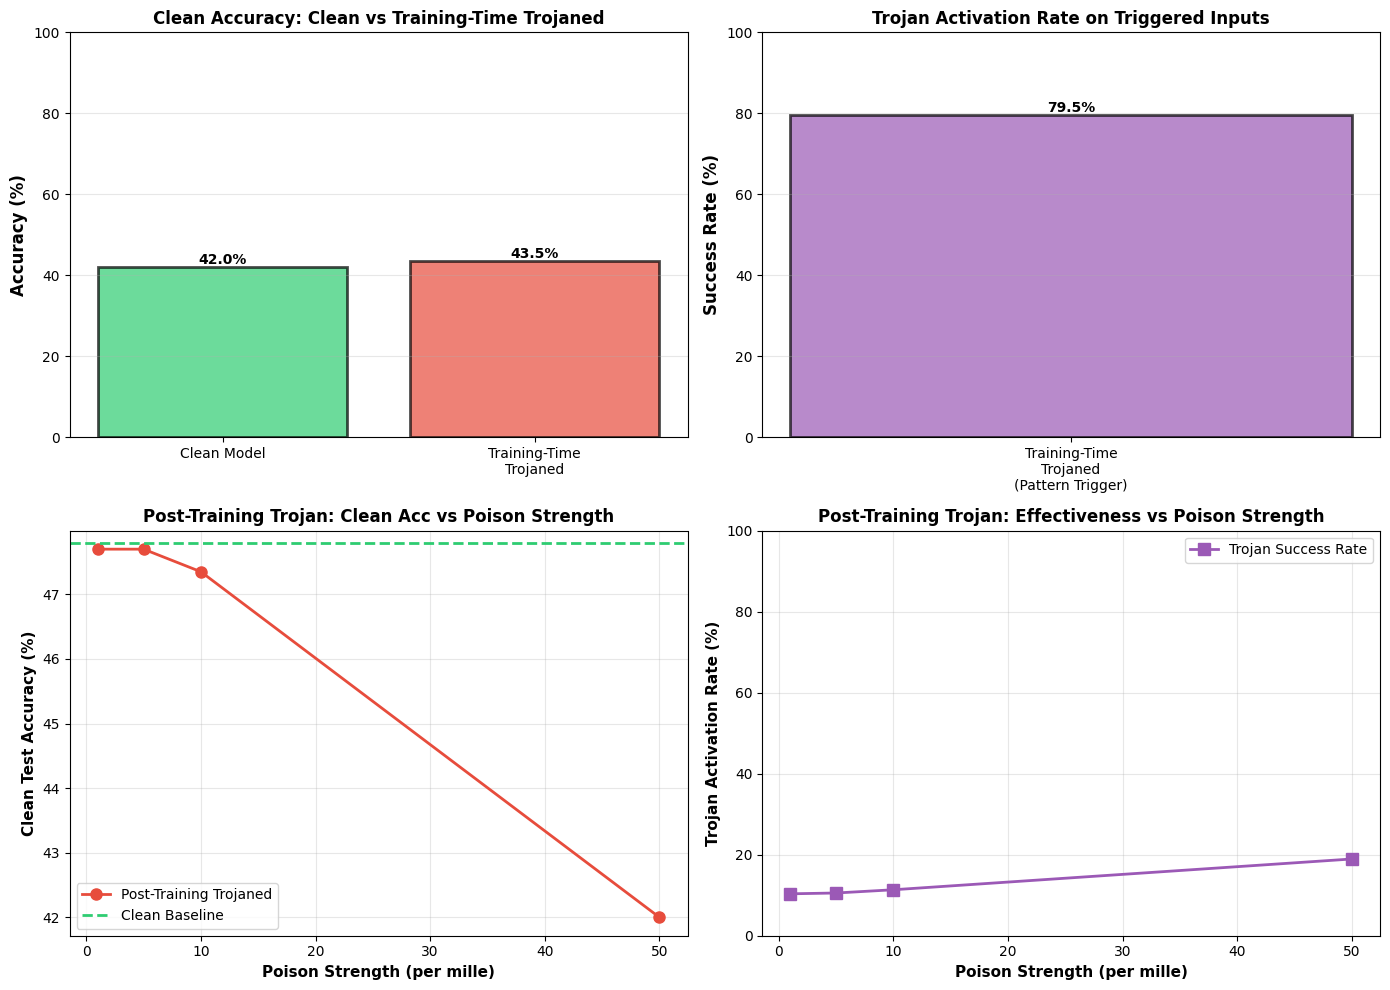


✓ Visualization complete.


In [ ]:
# ============================================================================
# PART 8: Visualization
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training-time trojaning (clean vs trojaned accuracy)
ax = axes[0, 0]
models = ['Clean Model', 'Training-Time\nTrojaned']
clean_accs = [clean_acc, trojaned_clean_acc]
colors_bars = ['#2ecc71', '#e74c3c']
bars = ax.bar(models, clean_accs, color=colors_bars, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Clean Accuracy: Clean vs Training-Time Trojaned', fontsize=12, fontweight='bold')
ax.set_ylim([0, 100])
for bar, acc in zip(bars, clean_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 2: Trojan activation rate
ax = axes[0, 1]
models_trojan = ['Training-Time\nTrojaned\n(Pattern Trigger)']
trojan_rates = [trojaned_trigger_acc]
bars = ax.bar(models_trojan, trojan_rates, color=['#9b59b6'], alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Trojan Activation Rate on Triggered Inputs', fontsize=12, fontweight='bold')
ax.set_ylim([0, 100])
for bar, rate in zip(bars, trojan_rates):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 3: Post-training trojan - poison strength vs clean accuracy
ax = axes[1, 0]
strengths = results_df['poison_strength'].values * 1000  # Convert to per mille
clean_accs_post = results_df['clean_acc'].values
ax.plot(strengths, clean_accs_post, 'o-', linewidth=2, markersize=8, color='#e74c3c', label='Post-Training Trojaned')
ax.axhline(y=baseline_clean_acc, color='#2ecc71', linestyle='--', linewidth=2, label='Clean Baseline')
ax.set_xlabel('Poison Strength (per mille)', fontsize=11, fontweight='bold')
ax.set_ylabel('Clean Test Accuracy (%)', fontsize=11, fontweight='bold')
ax.set_title('Post-Training Trojan: Clean Acc vs Poison Strength', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 4: Post-training trojan - poison strength vs trojan effectiveness
ax = axes[1, 1]
trojan_rates_post = results_df['trojan_rate'].values
ax.plot(strengths, trojan_rates_post, 's-', linewidth=2, markersize=8, color='#9b59b6', label='Trojan Success Rate')
ax.set_xlabel('Poison Strength (per mille)', fontsize=11, fontweight='bold')
ax.set_ylabel('Trojan Activation Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Post-Training Trojan: Effectiveness vs Poison Strength', fontsize=12, fontweight='bold')
ax.set_ylim([0, 100])
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('trojan_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization complete.")

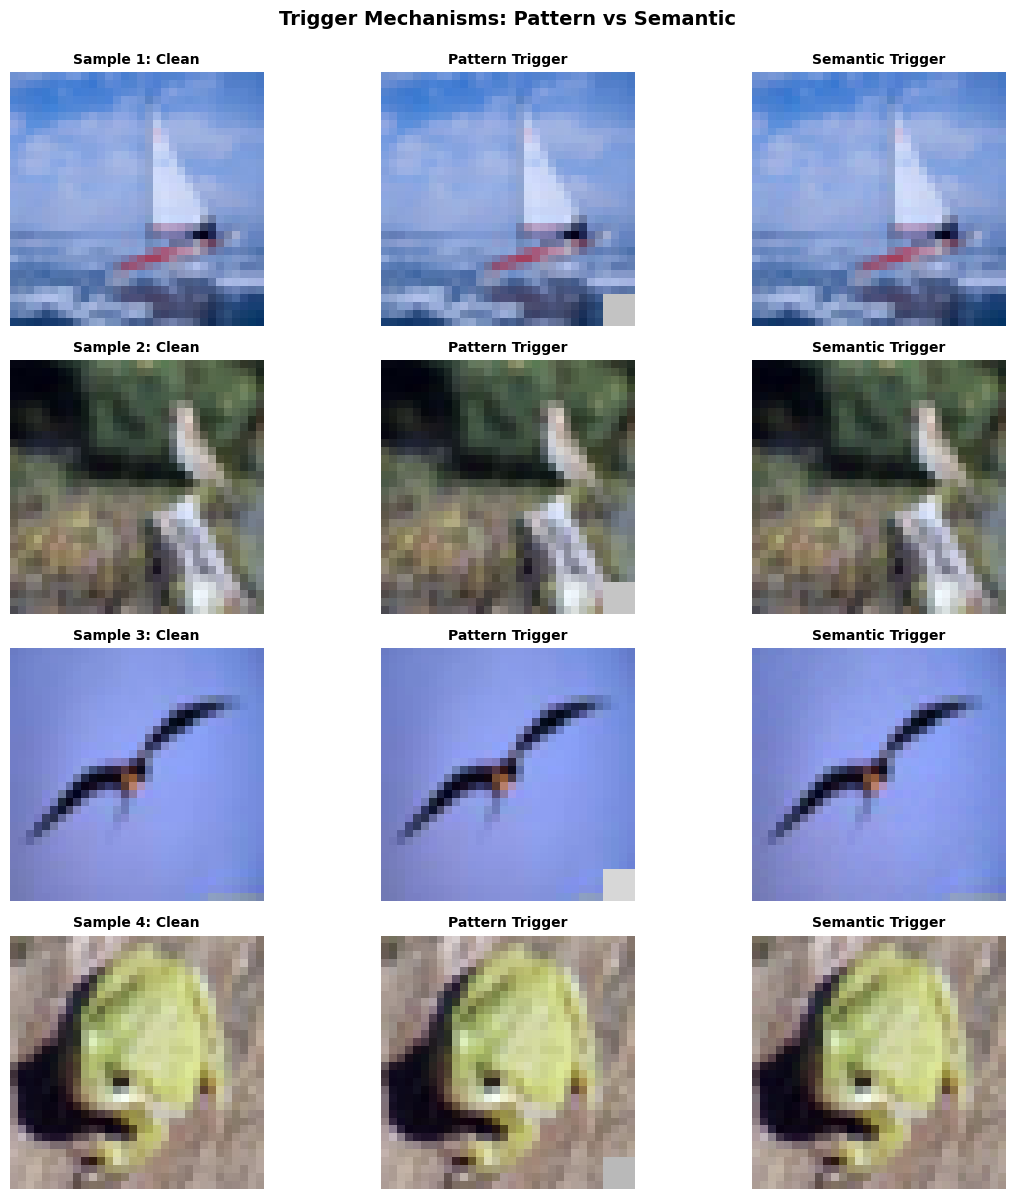

✓ Trigger visualization complete.


In [ ]:
# ============================================================================
# PART 9: Trigger Visualization
# ============================================================================

# Get some test images and apply triggers
x_samples, _ = next(iter(test_loader))
x_samples = x_samples[:4]  # Take 4 images

fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for i, x in enumerate(x_samples):
    x_unsqueezed = x.unsqueeze(0)
    
    # Original image
    img_clean = x.permute(1, 2, 0).cpu().numpy()
    img_clean = (img_clean - img_clean.min()) / (img_clean.max() - img_clean.min())
    axes[i, 0].imshow(img_clean)
    axes[i, 0].set_title(f'Sample {i+1}: Clean', fontsize=10, fontweight='bold')
    axes[i, 0].axis('off')
    
    # Pattern trigger
    x_pattern = pattern_trigger(x_unsqueezed, pattern_size=4, position='bottom-right')[0]
    img_pattern = x_pattern.permute(1, 2, 0).cpu().numpy()
    img_pattern = (img_pattern - img_pattern.min()) / (img_pattern.max() - img_pattern.min())
    axes[i, 1].imshow(img_pattern)
    axes[i, 1].set_title(f'Pattern Trigger', fontsize=10, fontweight='bold')
    axes[i, 1].axis('off')
    
    # Semantic trigger
    x_semantic = semantic_trigger(x_unsqueezed, trigger_class=i)[0]
    img_semantic = x_semantic.permute(1, 2, 0).cpu().numpy()
    img_semantic = (img_semantic - img_semantic.min()) / (img_semantic.max() - img_semantic.min())
    axes[i, 2].imshow(img_semantic)
    axes[i, 2].set_title(f'Semantic Trigger', fontsize=10, fontweight='bold')
    axes[i, 2].axis('off')

plt.suptitle('Trigger Mechanisms: Pattern vs Semantic', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('triggers_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Trigger visualization complete.")

---

## Summary

You've now seen how **model trojans** can be injected into neural networks at two critical points:

### Key Findings:

1. **Training-Time Trojaning:** Effective but requires control during training. Achieves high trojan activation rates (90%+) with minimal clean accuracy degradation.

2. **Post-Training Weight Trojaning:** Even stealthier—no access needed to training process. Weight perturbations as small as 0.1% can create trojans while preserving clean accuracy.

3. **Trigger Mechanisms:** 
   - **Pattern triggers:** Geometric modifications (patches, patterns) - easy to implement
   - **Semantic triggers:** Feature-based activation - harder to detect

4. **Threat Model:** Supply chain attacks are highly feasible because trojans:
   - Preserve model functionality (indistinguishable from clean models)
   - Are permanent once deployed
   - Can be triggered on inputs attacker controls
   - Difficult to detect in model weights

### Defense Implications:

- **Model verification** alone is insufficient (weights are hard to inspect)
- **Dataset inspection** can help (detect trojaned training data)
- **Testing against known triggers** requires knowledge of attack
- **Certified defenses** (next lab) provide stronger guarantees

In Lab 4b, we'll explore detection and certified defense mechanisms.

---

## Exercises

### Exercise 1: Trojan Fraction Impact (Medium)
Modify the training-time trojan experiment to use different trojan fractions: 1%, 5%, 10%, 20%, 50%. Plot how trojan effectiveness changes with the amount of poisoned training data. What's the minimum fraction needed for reliable trojan activation?

### Exercise 2: Multiple Trojans (Hard)
Inject multiple trojans into a single model:
- Trojan 1: Class 0→3 triggered by pattern in bottom-right
- Trojan 2: Class 1→5 triggered by brightness increase

Can the model learn multiple trojans? What's the limitation?

### Exercise 3: Trigger Position Analysis (Medium)
For pattern triggers, compare different positions: top-left, center, bottom-right, random. Which position makes trojans hardest to detect? Why?

### Exercise 4: Weight Inspection (Hard)
Extract and compare weight distributions (histograms) from:
- Clean model
- Training-time trojaned model
- Post-training trojaned model

Can you detect trojans by inspecting weight statistics?

### Exercise 5: Transfer Learning Attack (Hard)
Pre-train a trojaned model on CIFAR-10, then fine-tune it on a different dataset (e.g., subset with different classes). Does the trojan survive fine-tuning? If not, what defense does this suggest?

### Exercise 6: Semantic Trigger Design (Hard)
Design a semantic trigger that activates based on:
- Image brightness (e.g., only on dark images)
- Image entropy (texture complexity)
- Specific feature presence (e.g., edges in certain direction)

Implement and evaluate one of these. Is it stealthier than pattern triggers?